In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from easydict import EasyDict as edict

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict as ddict
from pprint import pprint

In [3]:
def sortdir(f):
    num = f.name.split("_")[-2].split("p")[-1]
    num = int(num)
    return  num

def sortf(f):
    num = f.name.split(".")[0]
    num = int(num)
    return num

In [4]:
def load_pkl(f):
    with open(f, "rb") as fi:
        data = pickle.load(fi)
    return data

## To obtaining simple format file

In [5]:
def parse_sresult(datum):
    res = {
        "JEF"  : datum["jef"]["theta"],
        "FULL": datum["full"]["theta"],
        "UIPD" : datum["UIPD"]["thetah"],
        "UIPJS": datum["UIPJS"]["thetah"],
        "NPP"  : datum["NPP"]["thetah"],
        "LCP"  : datum["LCP"]["thetah"],
        "rMAP" : datum["rMAP"]["thetaP"]
    }
    return res

def save_data(cdir):
    files = list(cdir.glob("*.pkl"))
    files = sorted(files, key=sortf, reverse=False)
    retres = {
        "JEF":[],
        "FULL":[],
        "LCP":[],
        "NPP":[],
        "UIPJS":[],
        "UIPD":[],
        "rMAP":[]
    }
    for fil in tqdm(files):
        datum = load_pkl(fil)
        simdatum = parse_sresult(datum)
        retres["JEF"].append(simdatum["JEF"])
        retres["FULL"].append(simdatum["FULL"])
        retres["UIPD"].append(simdatum["UIPD"])
        retres["UIPJS"].append(simdatum["UIPJS"])
        retres["NPP"].append(simdatum["NPP"])
        retres["LCP"].append(simdatum["LCP"])
        retres["rMAP"].append(simdatum["rMAP"])
    return retres

### Obain the folders

In [6]:
n = 120

root = Path(f"./results/")
dirs = root.glob(f"BiostatR1*_n{n}")
dirs = list(dirs)

### Get the current data

In [7]:
theta0 = 0.5

idxs = np.array([sortdir(d) for d in dirs])/100
idxs = list(np.sort(idxs))

dirs = sorted(dirs, key=sortdir, reverse=False)
cdir = dirs[idxs.index(theta0)]

simData = root/f"./SimBiostatR1_p{sortdir(cdir)}_n{n}.pkl"

### Obtain the cleaned data

In [8]:
if simData.exists():
    cleanData = load_pkl(simData)
else:
    cleanData = save_data(cdir)
    with open(simData, "wb") as f:
        pickle.dump(cleanData, f)

In [9]:
cleanData = edict(cleanData)

### Obtain the mean and variance and MSE from the posterior sample

In [10]:
def ObtainMSE(data, theta0):
    res = ddict(dict)
    for key in data.keys():
        datum = np.squeeze(np.array(data[key]))
        res[key]["Bias"] = np.mean(datum-theta0, axis=1)
        res[key]["Var"] = np.var(datum, axis=1)
        res[key]["MSE"] = np.mean((datum-theta0)**2, axis=1)
    return res

In [11]:
res = ObtainMSE(cleanData, theta0)

In [12]:
Biass = ddict()
for key in res.keys():
    Biass[key] = res[key]["Bias"]
BiasDF = pd.DataFrame(Biass)

In [13]:
Vars = ddict()
for key in res.keys():
    Vars[key] = res[key]["Var"]
VarDF = pd.DataFrame(Vars)

In [14]:
MSEs = ddict()
for key in res.keys():
    MSEs[key] = res[key]["MSE"]
MSEDF = pd.DataFrame(MSEs)

###  bias plot

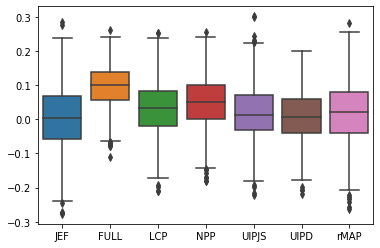

In [15]:
sns.boxplot(data=BiasDF)

In [16]:
BiasDF.mean()

JEF      0.003847
FULL     0.096319
LCP      0.031479
NPP      0.048904
UIPJS    0.017522
UIPD     0.008402
rMAP     0.017893
dtype: float64

### var plot

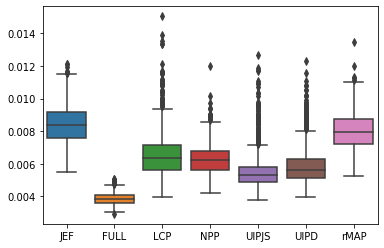

In [17]:
sns.boxplot(data=VarDF)

In [18]:
VarDF.mean()

JEF      0.008456
FULL     0.003873
LCP      0.006572
NPP      0.006283
UIPJS    0.005553
UIPD     0.005900
rMAP     0.008014
dtype: float64

### MSE plot

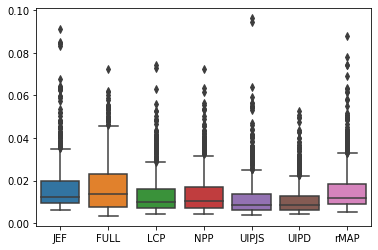

In [19]:
sns.boxplot(data=MSEDF)

#### MSE no full

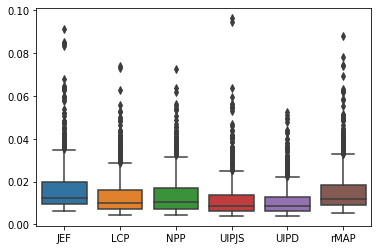

In [20]:
sns.boxplot(data=MSEDF.iloc[:, [0, 2, 3, 4, 5, 6]])

In [21]:
MSEDF.mean()

JEF      0.016697
FULL     0.016814
LCP      0.013173
NPP      0.013768
UIPJS    0.011801
UIPD     0.011032
rMAP     0.015762
dtype: float64

## Plot the bias, variance and MSE

In [23]:
n = 120
fls = root.glob(f"SimBiostatR1*_n{n}.pkl")
fls = list(fls)
fls = sorted(fls, key=sortdir)

In [24]:
bias = ddict(list)
varss = ddict(list)
mses = ddict(list)
thetas = []

In [25]:
for fl in fls:
    thetaC = sortdir(fl)/100
    thetas.append(thetaC)
    cleanData = load_pkl(fl)
    res = ObtainMSE(cleanData, thetaC)
    for key in res.keys():
        bias[key].append(np.mean(res[key]["Bias"]))
        varss[key].append(np.mean(res[key]["Var"]))
        mses[key].append(np.mean(res[key]["MSE"]))

No handles with labels found to put in legend.


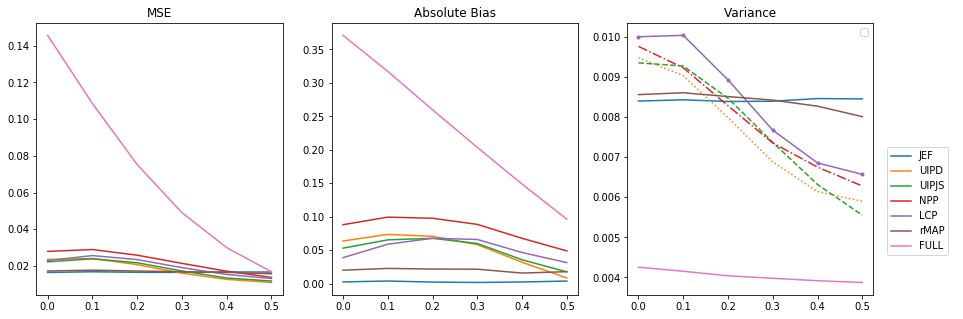

In [29]:
fig = plt.figure(figsize=[15, 5])
axes = fig.subplots(1, 3)

low = 0
up = 6
axes[0].set_title("MSE")
#axes[0].set_ylim([0, 0.05])
axes[0].plot(thetas[low:up], mses["JEF"][low:up], "-", label="JEF")
axes[0].plot(thetas[low:up], mses["UIPD"][low:up], label="UIPD")
axes[0].plot(thetas[low:up], mses["UIPJS"][low:up], label="UIPJS")
axes[0].plot(thetas[low:up], mses["NPP"][low:up], label="NPP")
axes[0].plot(thetas[low:up], mses["LCP"][low:up], label="LCP")
axes[0].plot(thetas[low:up], mses["rMAP"][low:up], label="rMAP")
axes[0].plot(thetas[low:up], mses["FULL"][low:up], label="FULL")
#plt.legend()

axes[1].set_title("Absolute Bias")
#axes[1].set_ylim([-0.01, 0.21])
axes[1].plot(thetas[low:up], np.abs(bias["JEF"][low:up]), "-", label="JEF")
axes[1].plot(thetas[low:up], np.abs(bias["UIPD"][low:up]), label="UIPD")
axes[1].plot(thetas[low:up], np.abs(bias["UIPJS"][low:up]), label="UIPJS")
axes[1].plot(thetas[low:up], np.abs(bias["NPP"][low:up]), label="NPP")
axes[1].plot(thetas[low:up], np.abs(bias["LCP"][low:up]), label="LCP")
axes[1].plot(thetas[low:up], np.abs(bias["rMAP"][low:up]), label="rMAP")
axes[1].plot(thetas[low:up], np.abs(bias["FULL"][low:up]), label="FULL")
plt.legend()


axes[2].set_title("Variance")
#axes[2].set_ylim([0.003, 0.01])
axes[2].plot(thetas[low:up], varss["JEF"][low:up], "-", label="JEF")
axes[2].plot(thetas[low:up], varss["UIPD"][low:up], ":", label="UIPD")
axes[2].plot(thetas[low:up], varss["UIPJS"][low:up], "--", label="UIPJS")
axes[2].plot(thetas[low:up], varss["NPP"][low:up], "-.", label="NPP")
axes[2].plot(thetas[low:up], varss["LCP"][low:up],".-", label="LCP")
axes[2].plot(thetas[low:up], varss["rMAP"][low:up], label="rMAP")
axes[2].plot(thetas[low:up], varss["FULL"][low:up], label="FULL")
#plt.legend()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.92, 0.20))

In [194]:
?plt.legend

<Figure size 1080x360 with 0 Axes>